In [24]:
%pip install bayesian-optimization
%pip install livelossplot
%pip install lightgbm

import matplotlib.pyplot as plt
import numpy as np
import os, contextlib, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import linear_model
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.preprocessing import quantile_transform, StandardScaler, RobustScaler
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPRegressor
from livelossplot import PlotLosses
import xgboost as xgb
import lightgbm as lgb

%cd /content/drive/My\ Drive/Colab\ Notebooks

np.random.seed(seed=1)

/content/drive/My Drive/Colab Notebooks


In [0]:
gpu = torch.device("cuda:0")

In [0]:
def loaddata(directory, t=True):
  
    feature_list = list()
    train_data_list = list()
    train_target_list = list()
    name = list()


    for i,filename in enumerate(os.listdir(directory)):
        data_matrix = np.genfromtxt(f'{directory}/{filename}')
        if filename == 'Data2scaled.txt': 
            name.append(filename)
            raw_data = np.genfromtxt('data/etalon_etalon_29May20.ccfSum-telemetry.csv',delimiter=',',names=True)
            feature_list.append(list(raw_data.dtype.names))
            test_data = data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]]
            test_target = data_matrix[:,1]
        else:
            train_data_list.append(data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]])
            train_target_list.append(data_matrix[:,1])
    feature_list = feature_list[0]
    feature_list.remove('RV')    


    if t == True:
      train_data_list = [quantile_transform(data,n_quantiles=100,copy=True) for data in train_data_list]
      test_data = quantile_transform(test_data,n_quantiles=100,copy=True)
      train_data_torch = [torch.from_numpy(data).unsqueeze(dim=1).float().to(gpu) for data in train_data_list]
      train_target_torch = [torch.from_numpy(data).unsqueeze(dim=1).float().to(gpu) for data in train_target_list]
      test_data_torch, test_target_torch = torch.from_numpy(np.array(test_data)).unsqueeze(dim=1).float().to(gpu), torch.from_numpy(np.array(test_target)).float().to(gpu)
      return train_data_torch, train_target_torch, test_data_torch, test_target_torch, np.array(feature_list,dtype=str)

    
    elif t == False:
      train_data_list = [quantile_transform(data,n_quantiles=100,copy=True) for data in train_data_list]
      test_data = quantile_transform(test_data,n_quantiles=100,copy=True)
      train_data = np.concatenate(train_data_list, axis=0)
      train_target = np.concatenate(train_target_list, axis=0)
      train_data = np.delete(train_data, 0, 1)
      test_data = np.delete(test_data, 0, 1)
      return train_data, train_target, test_data, test_target, name[0]

**Loading in data:** For gpu (torch-based, t=True) and cpu (sklearn-based, t=False)

In [0]:
train_data_torch, train_target_torch, test_data_torch, test_target_torch, feature_list = loaddata('Scaleddata', t=True)

In [0]:
train_data_numpy, train_target_numpy, test_data_numpy, test_target_numpy, name = loaddata('Scaleddata', t=False)

In [0]:
class LSTMTagger(nn.Module):

    def __init__(self, inputsize, layers, hiddensize, drop_out):
        super(LSTMTagger, self).__init__()
        self.inputsize = inputsize
        self.hiddensize = hiddensize
        self.layers = layers
        self.drop_out = drop_out

        self.lstm = nn.LSTM(input_size=self.inputsize, hidden_size = self.hiddensize, num_layers=layers, dropout=drop_out)
        self.hidden2radial = nn.Linear(in_features=hiddensize, out_features=1)

    def forward(self, x):
        x, _ = self.lstm(x)
        #x = F.elu(x)
        x = self.hidden2radial(x)
        return x

**Bayesian Optimization:** A generalized version to optimize both torch based and sklearn based algorithms

In [0]:
def val(inputsize: int, algorithm, data, targets, **params):
    param_list = list()
    for arg in params.values():
      param_list.append(arg)

    if algorithm == LSTMTagger:
      estimator = algorithm(inputsize, int(param_list[2]), int(param_list[1]), param_list[0])
      optimizer = torch.optim.Adam(estimator.parameters(),lr=param_list[3])
      judge = list()
      estimator = estimator.to(gpu)
      criterion = nn.MSELoss()
      for i,valdata in enumerate(train_data_torch):
          traindata = train_data_torch[:i] + train_data_torch[i+1:]
          traintarget = train_target_torch[:i] + train_target_torch[i+1:]
          valtarget = train_target_torch[i]
          judge_list = list()
          n_epochs = 100
          for e in range(n_epochs):
            estimator.train()
            epoch_losses = list()
            epoch_evs = list()
            acc_list = list()
            loss_list = list()
            for batch in range(len(traindata)):
              estimator.zero_grad()
              optimizer.zero_grad() 
              prediction = estimator(traindata[batch])
              target = traintarget[batch]
              # Calculating the loss function
              loss = criterion(prediction.squeeze(dim=2), target)
              # Calculating the gradient
              loss.backward()
              optimizer.step()
            with torch.no_grad():
              estimator.eval()
              train_prediction = estimator(valdata).squeeze(dim=1)
              loss_list.append( float(criterion((train_prediction),valtarget).detach().cpu()) )
              acc_list.append( explained_variance_score(valtarget.cpu(), train_prediction.cpu()) )
              #print(e, np.mean(loss_list),np.mean(acc_list))
            judge_list.append(np.mean(acc_list))
      return np.mean(judge_list)

    else:
      for key in params.keys():
        if params[key] >= 1:
          params[key] = int(params[key])
      estimator = algorithm(random_state=27, **params)
      cval = cross_val_score(estimator, data, targets, cv=5,scoring='explained_variance')
      return cval.mean()

def optimize(algorithm, data, targets, params, n_iter):
    def crossval_wrapper(data=data, targets=targets, **params):
        return val(inputsize = 27,
                   algorithm = algorithm, 
                   data = data, 
                   targets = targets, 
                   **params)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=params, 
                                     random_state=27, 
                                     verbose=2)
    optimizer.maximize(init_points=2, n_iter=n_iter)

    return optimizer

In [0]:
model_list = list()

**Long short term memory:**

In [9]:
params_LSTM = {"layers": (1, 3),
               "hiddensize": (100, 400),
               "drop_out": (0.2, 0.6),
               "lr": (0.0001, 0.00001)}

BO_LSTM = optimize(algorithm = LSTMTagger, data = train_data_torch, targets = train_target_torch, params = params_LSTM, n_iter = 6)

print(BO_LSTM.max)

max_params_LSTM = BO_LSTM.max['params']

|   iter    |  target   | drop_out  | hidden... |  layers   |    lr     |
-------------------------------------------------------------------------
|  1        |  0.8388   |  0.3703   |  344.4    |  2.471    |  2.188e-0 |
|  2        |  0.883    |  0.3534   |  393.8    |  2.786    |  8.113e-0 |


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5794010593306493 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


|  3        |  0.7524   |  0.5794   |  399.7    |  1.009    |  1e-05    |
|  4        |  0.602    |  0.5163   |  100.0    |  2.35     |  1e-05    |
|  5        |  0.7467   |  0.2294   |  216.7    |  2.987    |  1e-05    |
|  6        |  0.6417   |  0.4732   |  124.3    |  2.692    |  1e-05    |


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.266604824910106 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


|  7        |  0.7216   |  0.2666   |  391.4    |  1.813    |  1e-05    |
|  8        |  0.7725   |  0.2024   |  298.0    |  2.896    |  1e-05    |
{'target': 0.8829647785425186, 'params': {'drop_out': 0.3533523091490481, 'hiddensize': 393.83698964335616, 'layers': 2.7863886934302706, 'lr': 8.112563472210621e-05}}


In [10]:
criterion = nn.MSELoss()
judge = list()
for i,valdata in enumerate(train_data_torch):
      model = LSTMTagger(27,layers=int(max_params_LSTM['layers']), hiddensize=int(max_params_LSTM['hiddensize']),drop_out=max_params_LSTM['drop_out']).to(gpu)
      optimizer = optim.Adam(model.parameters(),lr=max_params_LSTM['lr'])

      traindata = train_data_torch[:i] + train_data_torch[i+1:]
      traintarget = train_target_torch[:i] + train_target_torch[i+1:]
      valtarget = train_target_torch[i]
      judge_list = list()

      plotlosses = PlotLosses()
      n_epochs = 100
      for e in range(n_epochs):
          model.train()
          epoch_losses = list()
          epoch_evs = list()
          acc_list = list()
          loss_list = list()
          for batch in range(len(traindata)):
              model.zero_grad()
              optimizer.zero_grad() 
              prediction = model(traindata[batch])
              target = traintarget[batch]
              # Calculating the loss function
              loss = criterion(prediction.squeeze(dim=2), target)
              epoch_losses.append(float(loss))
              evs = explained_variance_score(target.squeeze(dim=1).detach().cpu().numpy(),prediction.squeeze(dim=1).detach().cpu().numpy())
              epoch_evs.append(evs)
              # Calculating the gradient
              loss.backward()
              optimizer.step()
          with torch.no_grad():
              model.eval()
              train_prediction = model(valdata).squeeze(dim=1)
              loss_list.append( float(criterion((train_prediction),valtarget).detach().cpu()) )
              acc_list.append( explained_variance_score(valtarget.cpu(), train_prediction.cpu()) )
          print(e, np.mean(epoch_losses), np.mean(epoch_evs))
          judge_list.append(np.mean(acc_list))
      judge.append([np.mean(judge_list),model])
sorted(judge, key=lambda x: x[0])
winner = judge[0]
model_list.append(winner[1])

0 0.9958789745966593 0.004728456338246663
1 0.9819310307502747 0.01888968547185262
2 0.9689929882685343 0.032029410203297935
3 0.9536724289258321 0.04754668474197388
4 0.9367795586585999 0.06469591458638509
5 0.9169230858484904 0.0848168134689331
6 0.8918176889419556 0.11026948690414429
7 0.8640719453493754 0.13877445459365845
8 0.8245387673377991 0.17921713987986246
9 0.7697240511576334 0.23564298947652182
10 0.6975667675336202 0.3103318214416504
11 0.5955915252367655 0.41737620035807294
12 0.45896201332410175 0.5614033341407776
13 0.3101878861586253 0.7133896748224894
14 0.25648847470680874 0.7623393138249716
15 0.2794727385044098 0.7434447606404623
16 0.2166900336742401 0.7867833971977234
17 0.19837850332260132 0.80556720495224
18 0.20679772396882376 0.7986060579617819
19 0.20344978074232736 0.8012906511624655
20 0.1898506060242653 0.8135952353477478
21 0.1727204049626986 0.8317118684450785
22 0.1655131864051024 0.8398224910100301
23 0.16459576164682707 0.8410017490386963
24 0.15950

**Light GBM:**

In [11]:
params_LGBM = {'num_leaves': (2, 5),
               #'max_depth': (50, 500),
               'learning_rate': (0.01, 1)}

BO_LGBM = optimize(algorithm = lgb.LGBMRegressor, data = train_data_numpy, targets = train_target_numpy, params = params_LGBM, n_iter=30)

print(BO_LGBM.max)

max_params_LGBM = BO_LGBM.max['params']

model_LGBM = lgb.LGBMRegressor(num_leaves = int(max_params_LGBM['num_leaves']), 
                               #max_depth= int(max_params_LGBM['max_depth']), 
                               learning_rate = max_params_LGBM['learning_rate']
                               )
model_LGBM.fit(train_data_numpy, train_target_numpy)

model_list.append(model_LGBM)

|   iter    |  target   | learni... | num_le... |
-------------------------------------------------
|  1        | -0.2035   |  0.4315   |  4.444    |
|  2        | -0.3615   |  0.738    |  4.604    |
|  3        |  0.1464   |  0.01     |  2.0      |
|  4        | -0.6386   |  1.0      |  2.0      |
|  5        |  0.15     |  0.01     |  3.098    |
|  6        |  0.1447   |  0.01     |  5.0      |
|  7        |  0.1464   |  0.01     |  2.52     |
|  8        |  0.15     |  0.01     |  3.738    |
|  9        |  0.1519   |  0.01     |  4.466    |
|  10       |  0.1519   |  0.01     |  4.116    |
|  11       |  0.15     |  0.01     |  3.386    |
|  12       |  0.1519   |  0.01     |  4.704    |
|  13       |  0.1464   |  0.01     |  2.225    |
|  14       |  0.1498   |  0.01007  |  4.376    |
|  15       |  0.15     |  0.01     |  3.877    |
|  16       |  0.1519   |  0.01     |  4.802    |
|  17       |  0.1464   |  0.01     |  2.921    |
|  18       |  0.1405   |  0.01065  |  4.091    |


**XG Boost:**

In [12]:
params_XGB = {"eta": (0.1, 0.5),
               "max_depth": (1, 10),
               "num_round": (1, 40)}

BO_XGB = optimize(algorithm = xgb.XGBRegressor, data = train_data_numpy, targets = train_target_numpy, params = params_XGB, n_iter=30)

print(BO_XGB.max)

max_params_XGB = BO_XGB.max['params']

model_XGB = xgb.XGBRegressor(max_depth = int(max_params_XGB['max_depth']), 
                             num_round = int(max_params_XGB['num_round']),
                             eta = max_params_XGB['eta']
                             )             

model_XGB.fit(train_data_numpy, train_target_numpy)     

model_list.append(model_XGB)

|   iter    |  target   |    eta    | max_depth | num_round |
-------------------------------------------------------------
[19:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  1        |  0.06616  |  0.2703   |  8.331    |  29.68    |
[19:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:41] WARNING: /workspace/src/objective/regress

**Ordinary Least Squares:** No need for Bayesian Optimization \\
**Multi-Layer Perception:**

In [13]:
params_MLP = {"hidden_layer_sizes": (1, 200),
               "alpha": (0, 0.4),
               "learning_rate_init": (0.00001, 1)}

BO_MLP = optimize(algorithm = MLPRegressor, data = train_data_numpy, targets = train_target_numpy, params = params_MLP, n_iter=30)

print(BO_MLP.max)

max_params_MLP = BO_MLP.max['params']

model_MLP = MLPRegressor(hidden_layer_sizes= int(max_params_MLP['hidden_layer_sizes']),
                         alpha = max_params_MLP['alpha'],
                         learning_rate_init= max_params_MLP['learning_rate_init']
                         )
model_MLP.fit(train_data_numpy, train_target_numpy)

model_list.append(model_MLP)

|   iter    |  target   |   alpha   | hidden... | learni... |
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  1        | -0.2185   |  0.1703   |  163.1    |  0.7354   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  2        |  0.3975   |  0.3472   |  77.29    |  0.9795   |
|  3        | -0.03076  |  0.0      |  1.0      |  1e-05    |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  4        | -0.474    |  0.1917   |  75.39    |  0.3131   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  5        |  0.1674   |  0.3856   |  77.4     |  0.9241   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  6        |  0.1913   |  0.3907   |  76.42    |  0.9841   |
|  7        |  0.293    |  0.2008   |  31.84    |  0.1787   |
|  8        |  0.0      |  0.195    |  30.26    |  0.8411   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  9        |  0.1065   |  0.02639  |  33.51    |  0.5639   |
|  10       |  0.08497  |  0.2349   |  36.0     |  0.008072 |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  11       | -0.2267   |  0.4      |  38.53    |  1.0      |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  12       |  0.1439   |  0.2738   |  112.1    |  0.5374   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  13       |  0.2823   |  0.2663   |  114.2    |  0.9725   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  14       |  0.1078   |  0.0564   |  115.8    |  0.1561   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  15       | -0.09257  |  0.0791   |  109.7    |  0.5299   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  16       | -0.05146  |  0.08664  |  118.3    |  0.9661   |
|  17       | -0.5327   |  0.2969   |  58.58    |  0.07666  |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  18       |  0.07295  |  0.1179   |  94.56    |  0.7638   |
|  19       | -0.5019   |  0.1723   |  96.97    |  0.05128  |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  20       |  0.3167   |  0.1784   |  92.27    |  0.9519   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  21       |  0.008539 |  0.4      |  90.87    |  1e-05    |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  22       |  0.2551   |  0.1564   |  193.6    |  0.9409   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  23       | -0.04792  |  0.1523   |  191.8    |  0.6198   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  24       |  0.1172   |  0.2853   |  195.5    |  0.6979   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  25       |  0.241    |  0.2075   |  197.9    |  0.9755   |
|  26       |  0.03863  |  0.3904   |  199.6    |  0.02463  |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  27       | -0.6986   |  0.2569   |  137.6    |  0.8225   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  28       |  0.06669  |  0.216    |  15.37    |  0.7379   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  29       | -4.441e-1 |  0.3778   |  12.74    |  0.8051   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  30       |  0.1698   |  0.1482   |  18.0     |  0.5876   |


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  31       |  0.02945  |  0.01158  |  20.17    |  0.5388   |
|  32       | -0.316    |  0.3664   |  23.54    |  0.05381  |
{'target': 0.39754287245944814, 'params': {'alpha': 0.3472012799518943, 'hidden_layer_sizes': 77.29277380165142, 'learning_rate_init': 0.9794568375781991}}


**Ordinary Least Squares:**

In [0]:
model_OLS = linear_model.LinearRegression()
model_OLS.fit(train_data_numpy, train_target_numpy)
model_list.append(model_OLS)

**Plot:**

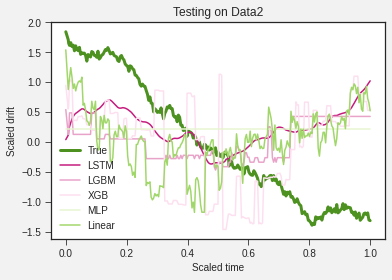

In [41]:
time = test_data_torch.cpu().squeeze().detach().numpy()[:,0]

fig = plt.figure('All models')
colorlist = ['#c51b7d', '#e9a3c9', '#fde0ef', '#e6f5d0', '#a1d76a', '#4d9221']
#colorlist = colorlist[::-1]
plt.plot(time, test_target_numpy, linestyle='-', linewidth=3, label='True', color=colorlist[-1])
for i,model in enumerate(model_list):
  if i == 0:
    prediction = model(test_data_torch).squeeze(dim=1).detach().cpu().numpy()
    plt.plot(time, prediction, linestyle='-',label=f'{model}'.split('(')[0].replace('Tagger',''), color=colorlist[i])
  elif i == len(model_list)-1:
    plt.plot(time, model.predict(test_data_numpy),linestyle='-',label=f'{model}'.split('(')[0].replace('Regression',''), color=colorlist[i])
  else:
    plt.plot(time, model.predict(test_data_numpy),linestyle='-',label=f'{model}'.split('(')[0].replace('Regressor',''), color=colorlist[i])
plt.legend(loc='best')
plt.title(f"Testing on {name.replace('scaled.txt','')}")
plt.xlabel('Scaled time')
plt.ylabel('Scaled drift')
plt.style.use('seaborn-white')
plt.style.use('seaborn-ticks')
fig.patch.set_facecolor('#f2f2f2')
plt.show()